# 查看根目录下需要运行的文件夹

In [4]:
from pathlib import Path

version = "v1"

path = Path("/workspace/models/SAHI/run_v8")
chosen_dirs = [d / "raw_data_sliced_merge" for d in path.iterdir() if d.is_dir()]
print("子文件夹路径列表：", chosen_dirs)

子文件夹路径列表： [PosixPath('/workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge')]


# 统计各类别数量并导出为CSV文件

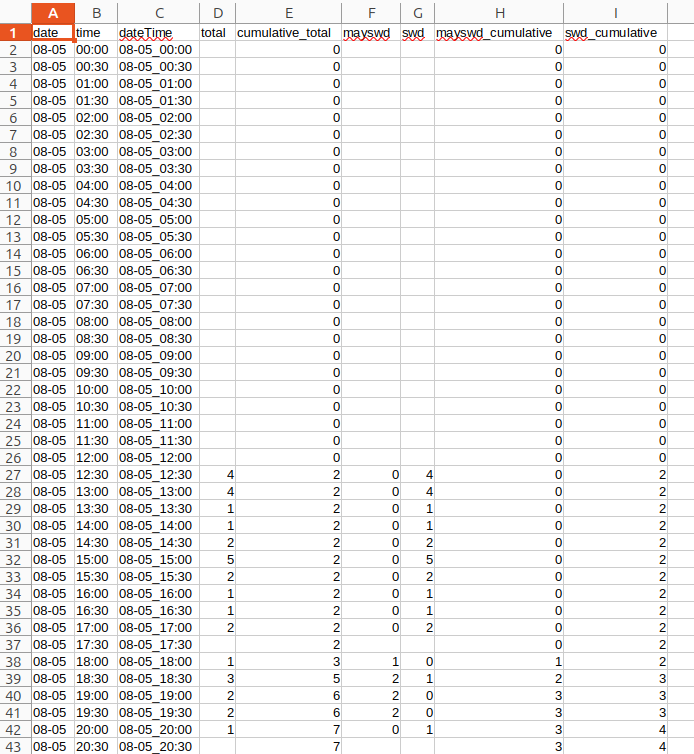

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from pathlib import Path
from collections import defaultdict, Counter
from typing import Any, Dict, Iterable, List, Optional, Tuple
import orjson, csv, re, math, statistics

# ================== 可选：shapely ==================
try:
    from shapely.geometry import Polygon
    _HAVE_SHAPELY = True
except Exception:
    _HAVE_SHAPELY = False

# ================== Debug 打印工具 ==================
def _short_list(lst, n=3):
    try:
        seq = list(lst)
    except Exception:
        seq = [lst]
    return f"{seq[:n]}{'...' if len(seq) > n else ''}"

def _print(title: str, debug_level: int, level_needed: int = 1, **kv):
    if debug_level >= level_needed:
        print(f"\n==== {title} ====")
        for k, v in kv.items():
            print(f"- {k}: {v}")

# ================== 时间解析 ==================
# 期望文件名中包含 "MMDD_HHMM" 片段，例如 0729_0636_620
_FN_RE = re.compile(r"(?P<mm>\d{2})(?P<dd>\d{2})_(?P<hh>\d{2})(?P<mi>\d{2})")

def _parse_mmdd_hhmm(img_name: str):
    m = _FN_RE.search(img_name)
    if not m:
        return None
    mm, dd, hh, mi = m.group("mm", "dd", "hh", "mi")
    return f"{mm}-{dd}", f"{hh}:{mi}"

def _to_slot(time_str: str, step_min: int):
    hh, mi = map(int, time_str.split(":"))
    total_min = hh * 60 + mi
    slot_min = (total_min // step_min) * step_min
    h, m = divmod(slot_min, 60)
    return f"{h:02d}:{m:02d}"

def _day_slots(step_min: int):
    return [f"{(t//60):02d}:{(t%60):02d}" for t in range(0, 24*60, step_min)]

# ================== IO ==================
def _read_json_file(p: Path):
    with p.open("rb") as f:
        return orjson.loads(f.read())

def _normalize_to_list(data) -> List[Dict[str, Any]]:
    """
    将顶层 dict/list 统一为 list[dict]。
    若是 dict: { "IMGNAME": [ {...}, ...], ... }，则为每个元素补上 original_name。
    """
    if isinstance(data, list):
        return data
    elif isinstance(data, dict):
        out = []
        for img, arr in data.items():
            if not isinstance(arr, list):
                continue
            for obj in arr:
                if isinstance(obj, dict):
                    if "original_name" not in obj and "image" not in obj and "filename" not in obj and "name" not in obj:
                        obj = dict(obj)
                        obj["original_name"] = str(img)
                    out.append(obj)
        return out
    else:
        raise ValueError("不支持的 JSON 顶层结构：需要 list 或 dict")

def _load_data(data_or_path, *, debug_level=1):
    """
    支持：
      - in-memory list/dict
      - 单个 .json 文件
      - 目录：递归加载所有 .json -> 合并为一个 list
    """
    if isinstance(data_or_path, (dict, list)):
        data = _normalize_to_list(data_or_path)
        src = "in-memory"
    else:
        p = Path(data_or_path)
        if p.is_dir():
            items = []
            files = sorted(p.rglob("*.json"))
            for jf in files:
                try:
                    items.extend(_normalize_to_list(_read_json_file(jf)))
                except Exception as e:
                    _print("读取 JSON 失败（已跳过）", debug_level, 1, file=str(jf), error=str(e))
            data = items
            src = f"dir:{p} ({len(files)} files)"
        else:
            data = _normalize_to_list(_read_json_file(p))
            src = str(p)

    _print("STEP 1: 加载数据 (输入)", debug_level, 1,
           source=src,
           type=type(data).__name__,
           records=len(data))
    return data

def save_csv(path: str | Path, header, rows, *, debug_level=1):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(header)
        w.writerows(rows)
    _print("保存 CSV (输出)", debug_level, 1,
           path=str(path),
           rows=len(rows),
           header_cols=len(header))

# ================== 输入结构自适配：按图片名分组 ==================
def _group_by_image(data: List[Dict[str, Any]], image_key=None, *, debug_level=1):
    """
    data 已经统一为 list[dict]
    image_key 优先；否则自动从 ["original_name","image","filename","name"] 猜测
    返回: dict[str, list[dict]]
    """
    grouped: Dict[str, List[Dict[str, Any]]] = defaultdict(list)
    cand = [image_key] if image_key else ["original_name", "image", "filename", "name"]

    for obj in data:
        if not isinstance(obj, dict):
            continue
        img = None
        for k in cand:
            if k and obj.get(k) is not None:
                img = str(obj[k]); break
        if img is None:
            continue
        grouped[img].append(obj)

    num_images = len(grouped)
    num_records = sum(len(v) for v in grouped.values())
    _print("STEP 2: 按图片分组 (输入→输出)", debug_level, 1,
           input_type="list",
           output_images=num_images,
           output_records=num_records,
           sample_images=_short_list(list(grouped.keys()), 5))
    return grouped

# ================== 几何提取（polygon 优先） ==================
def _poly_from_segments(segments: Dict[str, List[float]]) -> Optional[List[List[float]]]:
    xs = segments.get("x") or segments.get("xs") or []
    ys = segments.get("y") or segments.get("ys") or []
    if not xs or not ys or len(xs) != len(ys):
        return None
    return [[float(x), float(y)] for x, y in zip(xs, ys)]

def _poly_from_bbox(b) -> Optional[List[List[float]]]:
    # 接受 [x,y,w,h] / {x,y,w,h} / [x1,y1,x2,y2]
    if b is None:
        return None
    try:
        if isinstance(b, (list, tuple)) and len(b) >= 4:
            x, y, w, h = map(float, b[:4])
            if w > 0 and h > 0:
                x1, y1, x2, y2 = x, y, x + w, y + h
            else:
                x1, y1, x2, y2 = map(float, b[:4])
        elif isinstance(b, dict):
            if all(k in b for k in ("x1", "y1", "x2", "y2")):
                x1, y1, x2, y2 = float(b["x1"]), float(b["y1"]), float(b["x2"]), float(b["y2"])
            else:
                x = float(b.get("x"))
                y = float(b.get("y"))
                w = float(b.get("w") or b.get("width"))
                h = float(b.get("h") or b.get("height"))
                x1, y1, x2, y2 = x, y, x + w, y + h
        else:
            return None
        if x2 <= x1 or y2 <= y1:
            return None
        return [[x1, y1], [x2, y1], [x2, y2], [x1, y2]]
    except Exception:
        return None

def _poly_from_obj(obj: Dict[str, Any]) -> Optional[List[List[float]]]:
    # 1) points
    pts = obj.get("points") or obj.get("polygon")
    if isinstance(pts, list) and len(pts) >= 3:
        return [[float(x), float(y)] for x, y in pts]
    # 2) segments {x:[], y:[]}
    seg = obj.get("segments") or obj.get("segment")
    if isinstance(seg, dict):
        p = _poly_from_segments(seg)
        if p:
            return p
    # 3) box / bbox
    box = obj.get("box") or obj.get("Box") or None
    if box is not None:
        p = _poly_from_bbox(box)
        if p:
            return p
    bb = obj.get("bbox") or obj.get("BBox") or None
    if bb is not None:
        p = _poly_from_bbox(bb)
        if p:
            return p
    return None

def _poly_to_bbox(poly: List[List[float]]) -> Tuple[float, float, float, float]:
    xs = [p[0] for p in poly]; ys = [p[1] for p in poly]
    return min(xs), min(ys), max(xs), max(ys)

def _bbox_center(b: Tuple[float, float, float, float]) -> Tuple[float, float]:
    return (b[0] + b[2]) * 0.5, (b[1] + b[3]) * 0.5

def _center_distance(b1, b2) -> float:
    c1 = _bbox_center(b1); c2 = _bbox_center(b2)
    return math.hypot(c1[0] - c2[0], c1[1] - c2[1])

# ================== 匹配度量（IOS/IOU，Polygon 优先） ==================
def _area_bbox(b):
    return max(0.0, b[2] - b[0]) * max(0.0, b[3] - b[1])

def _iou_bbox(a, b) -> float:
    xA = max(a[0], b[0]); yA = max(a[1], b[1])
    xB = min(a[2], b[2]); yB = min(a[3], b[3])
    inter = max(0.0, xB - xA) * max(0.0, yB - yA)
    if inter <= 0:
        return 0.0
    u = _area_bbox(a) + _area_bbox(b) - inter
    return inter / u if u > 0 else 0.0

def _ios_bbox(a, b) -> float:
    xA = max(a[0], b[0]); yA = max(a[1], b[1])
    xB = min(a[2], b[2]); yB = min(a[3], b[3])
    inter = max(0.0, xB - xA) * max(0.0, yB - yA)
    if inter <= 0:
        return 0.0
    smaller = min(_area_bbox(a), _area_bbox(b))
    return inter / smaller if smaller > 0 else 0.0

def _iou_poly(pa: List[List[float]], pb: List[List[float]]) -> float:
    if not _HAVE_SHAPELY:
        return _iou_bbox(_poly_to_bbox(pa), _poly_to_bbox(pb))
    try:
        A = Polygon(pa); B = Polygon(pb)
        inter = A.intersection(B).area
        if inter <= 0:
            return 0.0
        u = A.area + B.area - inter
        return inter / u if u > 0 else 0.0
    except Exception:
        return _iou_bbox(_poly_to_bbox(pa), _poly_to_bbox(pb))

def _ios_poly(pa: List[List[float]], pb: List[List[float]]) -> float:
    if not _HAVE_SHAPELY:
        return _ios_bbox(_poly_to_bbox(pa), _poly_to_bbox(pb))
    try:
        A = Polygon(pa); B = Polygon(pb)
        inter = A.intersection(B).area
        if inter <= 0:
            return 0.0
        smaller = min(A.area, B.area)
        return inter / smaller if smaller > 0 else 0.0
    except Exception:
        return _ios_bbox(_poly_to_bbox(pa), _poly_to_bbox(pb))

# ================== STEP 2.5: 清晰度筛选（按槽 / 按天） ==================
def _image_level_score(values: List[Optional[float]], agg: str) -> Optional[float]:
    vals = [v for v in values if isinstance(v, (int, float))]
    if not vals:
        return None
    if agg == "max":
        return max(vals)
    elif agg == "mean":
        return sum(vals) / len(vals)
    elif agg == "median":
        return statistics.median(vals)
    else:
        return max(vals)

def _collect_metric_samples(grouped: Dict[str, List[Dict[str, Any]]], clarity_metric: str) -> List[float]:
    samples = []
    for arr in grouped.values():
        for obj in arr:
            v = obj.get(clarity_metric, None)
            if isinstance(v, (int, float)):
                samples.append(float(v))
    return samples

def _score_images(grouped: Dict[str, List[Dict[str, Any]]],
                  clarity_metric: str,
                  image_score_agg: str,
                  handle_missing_clarity: str,
                  global_median: Optional[float]) -> Dict[str, Optional[float]]:
    """
    返回每张图片的“图片级清晰度分数”
    """
    scores: Dict[str, Optional[float]] = {}
    for img, arr in grouped.items():
        vals = []
        for obj in arr:
            v = obj.get(clarity_metric, None)
            if v is None:
                if handle_missing_clarity == "zero":
                    vals.append(0.0)
                elif handle_missing_clarity == "impute-median" and global_median is not None:
                    vals.append(global_median)
            elif isinstance(v, (int, float)):
                vals.append(float(v))
        s = _image_level_score(vals, image_score_agg)
        scores[img] = s
    return scores

def _tie_key(img: str, tie_policy: str):
    m = _FN_RE.search(img)
    if m:
        mm, dd, hh, mi = (int(m.group("mm")), int(m.group("dd")), int(m.group("hh")), int(m.group("mi")))
        if tie_policy == "latest":
            return (-mm, -dd, -hh, -mi, img)  # 让“更晚”的时间在排序时优先
        else:
            return (mm, dd, hh, mi, img)
    # 没有时间信息时回退文件名
    return (img,)

def _select_topk_indexes(sorted_pairs: List[Tuple[str, float]],
                         top_k: int,
                         min_threshold: Optional[float],
                         ensure_one: bool) -> List[int]:
    """
    输入已按分数降序的 (img, score) 列表，返回入选下标列表。
    """
    selected: List[int] = []
    if min_threshold is None:
        for i, _ in enumerate(sorted_pairs):
            if len(selected) >= top_k:
                break
            selected.append(i)
    else:
        for i, (_, s) in enumerate(sorted_pairs):
            if s is not None and s >= min_threshold:
                selected.append(i)
                if len(selected) >= top_k:
                    break
        if ensure_one and not selected and sorted_pairs:
            selected = [0]
    return selected

def _filter_by_clarity(
    grouped: Dict[str, List[Dict[str, Any]]],
    *,
    clarity_filter_mode: Optional[str],   # None | "per_slot" | "per_day"
    clarity_metric: str = "tenengrad_score",
    image_score_agg: str = "max",         # "max" | "mean" | "median"
    top_k: int = 1,
    step_min: int = 30,                   # per_slot 用
    min_threshold: Optional[float] = None,
    ensure_coverage: bool = False,        # per_slot 用：若某槽无候选时，是否保 1 张
    handle_missing_clarity: str = "drop", # "drop" | "zero" | "impute-median"
    tie_policy: str = "earliest",         # "earliest" | "latest"
    debug_level: int = 1,
):
    """
    返回：filtered_grouped, selection_map, stats
    selection_map:
      - per_slot:  {(date, slot): [img1, img2, ...]}  按分数降序
      - per_day:   {(date, "__DAY__"): [img1, img2, ...]}  按分数降序
    """
    if clarity_filter_mode is None:
        _print("STEP 2.5: 清晰度筛选（跳过）", debug_level, 1, enabled=False)
        return grouped, {}, {"enabled": False}

    samples = _collect_metric_samples(grouped, clarity_metric)
    global_median = statistics.median(samples) if (samples and handle_missing_clarity == "impute-median") else None
    img_score = _score_images(grouped, clarity_metric, image_score_agg, handle_missing_clarity, global_median)

    # 建桶
    buckets: Dict[Tuple[str, str], List[str]] = defaultdict(list)
    for img in grouped.keys():
        parsed = _parse_mmdd_hhmm(img)
        if not parsed:
            continue
        d, t = parsed
        if clarity_filter_mode == "per_slot":
            key = (d, _to_slot(t, step_min))
        elif clarity_filter_mode == "per_day":
            key = (d, "__DAY__")
        else:
            continue
        buckets[key].append(img)

    selected_imgs = set()
    selection_map: Dict[Tuple[str, str], List[str]] = {}
    per_bucket_info = []

    for key, imgs in buckets.items():
        pairs: List[Tuple[str, float]] = []
        for img in imgs:
            s = img_score.get(img, None)
            if s is None and handle_missing_clarity == "drop":
                continue
            pairs.append((img, s if s is not None else 0.0))

        if tie_policy not in ("earliest", "latest"):
            tie_policy = "earliest"
        pairs_sorted = sorted(
            pairs,
            key=lambda p: (-p[1], _tie_key(p[0], tie_policy))
        )

        idxs = _select_topk_indexes(
            pairs_sorted,
            top_k=top_k,
            min_threshold=min_threshold,
            ensure_one=(ensure_coverage if clarity_filter_mode == "per_slot" else False)
        )
        chosen = [pairs_sorted[i][0] for i in idxs]
        selection_map[key] = chosen[:]  # 保存降序列表
        selected_imgs.update(chosen)

        if debug_level >= 2:
            per_bucket_info.append({
                "bucket": key,
                "candidates": len(pairs_sorted),
                "chosen_topk": len(chosen),
                "examples": [(img, float(f"{score:.4f}")) for img, score in pairs_sorted[:min(5, len(pairs_sorted))]],
                "selected": chosen[:min(5, len(chosen))]
            })

    filtered = {img: grouped[img] for img in selected_imgs}
    _print("STEP 2.5: 清晰度筛选 (输入→输出)", debug_level, 1,
           enabled=True,
           mode=clarity_filter_mode,
           step_min=step_min if clarity_filter_mode == "per_slot" else None,
           top_k=top_k,
           metric=clarity_metric,
           agg=image_score_agg,
           min_threshold=min_threshold,
           ensure_coverage=(ensure_coverage if clarity_filter_mode == "per_slot" else None),
           handle_missing=handle_missing_clarity,
           buckets=len(buckets),
           images_before=len(grouped),
           images_after=len(filtered))
    if debug_level >= 2 and per_bucket_info:
        for info in per_bucket_info[:8]:
            _print("  ▷ 桶示例", debug_level, 2,
                   bucket=str(info["bucket"]),
                   candidates=info["candidates"],
                   chosen_topk=info["chosen_topk"],
                   examples=info["examples"],
                   selected=info["selected"])

    return filtered, selection_map, {
        "enabled": True,
        "mode": clarity_filter_mode,
        "images_before": len(grouped),
        "images_after": len(filtered),
        "buckets": len(buckets),
    }


# ================== Step 3: 提取计数与几何 ==================
def _extract_counts_and_dets(grouped: Dict[str, List[Dict[str, Any]]],
                             label_key: str,
                             *,
                             debug_level=1):
    per_img_counts: Dict[str, Counter] = {}
    per_img_dets: Dict[str, List[Dict[str, Any]]] = defaultdict(list)
    all_labels = set()
    tot_objects = 0

    for img, arr in grouped.items():
        c = Counter()
        dets = []
        for obj in arr:
            if not isinstance(obj, dict):
                continue
            label = obj.get(label_key) or obj.get("class_name") or obj.get("category")
            if label is None:
                continue
            label = str(label)
            all_labels.add(label)
            c[label] += 1
            poly = _poly_from_obj(obj)
            dets.append({"label": label, "poly": poly})
            tot_objects += 1

        if c:
            per_img_counts[img] = c
            per_img_dets[img] = dets

    if not per_img_counts:
        raise ValueError("没有统计到任何数据（检查 label_key / image_key / JSON 结构 / 清晰度筛选结果）")

    labels_sorted = sorted(all_labels)
    _print("STEP 3: 提取计数与几何 (输入→输出)", debug_level, 1,
           images=len(per_img_counts),
           total_objects=tot_objects,
           labels=labels_sorted)
    return per_img_counts, per_img_dets, labels_sorted

# ================== Step 4: 聚合到 (date, time_slot) ==================
def _aggregate_to_slots(per_img_counts: Dict[str, Counter],
                        per_img_dets: Dict[str, List[Dict[str, Any]]],
                        step_min: int,
                        fill_full_day: bool,
                        *,
                        debug_level=1):
    ts_counts = defaultdict(lambda: defaultdict(Counter))  # date -> time -> Counter
    ts_dets   = defaultdict(lambda: defaultdict(list))     # date -> time -> List[det]
    present_times = defaultdict(set)                       # date -> set(times)
    dates = set()

    for img, cnt in per_img_counts.items():
        parsed = _parse_mmdd_hhmm(img)
        if not parsed:
            continue
        d, t_raw = parsed
        dates.add(d)
        slot = _to_slot(t_raw, step_min)

        ts_counts[d][slot].update(cnt)
        present_times[d].add(slot)
        ts_dets[d][slot].extend(per_img_dets.get(img, []))

    if not dates:
        raise ValueError("文件名未匹配到 MMDD_HHMM，无法生成时间序列。")

    all_slots = _day_slots(step_min)
    if fill_full_day:
        for d in dates:
            for t in all_slots:
                _ = ts_counts[d][t]

    num_slots_real = sum(len(v) for v in present_times.values())
    num_slots_total = sum(len(v) for v in ts_counts.values())
    _print("STEP 4: 聚合到时间槽 (输入→输出)", debug_level, 1,
           dates=len(dates),
           slots_real=num_slots_real,
           slots_total=num_slots_total,
           step_min=step_min,
           fill_full_day=fill_full_day)

    return ts_counts, ts_dets, present_times, dates, all_slots

# ================== 匹配函数构建 ==================
def _build_matcher(match_metric: Optional[str],
                   match_threshold: float,
                   center_thresh: Optional[float]):
    if match_metric is None:
        def _zero_score(a, b): return 0.0
        return _zero_score

    mode = match_metric.lower()

    def _score(poly_a, poly_b):
        if "poly" in mode and (poly_a is not None) and (poly_b is not None):
            score = _ios_poly(poly_a, poly_b) if "ios" in mode else _iou_poly(poly_a, poly_b)
        else:
            ba = _poly_to_bbox(poly_a) if poly_a is not None else None
            bb = _poly_to_bbox(poly_b) if poly_b is not None else None
            if (ba is None) or (bb is None):
                return 0.0
            if center_thresh is not None and _center_distance(ba, bb) > center_thresh:
                return 0.0
            score = _ios_bbox(ba, bb) if "ios" in mode else _iou_bbox(ba, bb)
        return score

    return _score

# ================== Step 5: 生成时间序列行 ==================
def _unique_in_slot(dets_raw: List[Dict[str, Any]],
                    match_score,
                    match_threshold: float,
                    center_thresh: Optional[float],
                    class_agnostic: bool,
                    *,
                    debug_level=1,
                    date: str = "",
                    time: str = "") -> List[Dict[str, Any]]:
    unique_now: List[Dict[str, Any]] = []
    for det in dets_raw:
        poly = det.get("poly")
        label = det.get("label", "")
        cur = {"label": label, "poly": poly}

        dup_in_row = False
        for u in unique_now:
            if (not class_agnostic) and (u["label"] != cur["label"]):
                continue
            if center_thresh is not None:
                bu = _poly_to_bbox(u["poly"]) if u["poly"] is not None else None
                bc = _poly_to_bbox(cur["poly"]) if cur["poly"] is not None else None
                if bu is not None and bc is not None and _center_distance(bu, bc) > center_thresh:
                    continue
            if match_score(u["poly"], cur["poly"]) >= match_threshold:
                dup_in_row = True
                break
        if not dup_in_row:
            unique_now.append(cur)

    _print("  ▷ 槽内去重 (输入→输出)", debug_level, 2,
           slot=f"{date}_{time}",
           raw=len(dets_raw),
           unique=len(unique_now))
    return unique_now

def _already_seen(det: Dict[str, Any],
                  seen_pool,
                  match_score,
                  match_threshold: float,
                  center_thresh: Optional[float]) -> bool:
    for s in seen_pool:
        if center_thresh is not None:
            ba = _poly_to_bbox(det["poly"]) if det["poly"] is not None else None
            bb = _poly_to_bbox(s["poly"])   if s["poly"]   is not None else None
            if ba is not None and bb is not None and _center_distance(ba, bb) > center_thresh:
                continue
        if match_score(det["poly"], s["poly"]) >= match_threshold:
            return True
    return False

def _remember(det: Dict[str, Any], seen_pool):
    seen_pool.append({"label": det["label"], "poly": det["poly"]})

def _build_rows(ts_counts, ts_dets, present_times, dates, all_slots, labels_sorted,
                *,
                cumulative: bool,
                match_metric: Optional[str],
                match_threshold: float,
                center_thresh: Optional[float],
                class_agnostic: bool,
                carry_cum_on_pad: bool,
                pad_value,
                step_min: int,
                # 新增：用于写出 last_selected_image
                selection_map: Optional[Dict[Tuple[str, str], List[str]]] = None,
                clarity_filter_mode: Optional[str] = None,
                debug_level: int = 1):
    """
    根据聚合结果生成最终表格行。
    额外输出列: 'last_selected_image'
    """
    # 表头：在 dateTime 后面插入 last_selected_image
    header = ["date", "time", "dateTime", "last_selected_image", "total"]
    if cumulative:
        header.append("cumulative_total")
    header.extend(labels_sorted)
    if cumulative:
        header.extend([f"{lbl}_cumulative" for lbl in labels_sorted])

    match_score = _build_matcher(match_metric, match_threshold, center_thresh)

    running_cum = 0
    running_cum_by_label = {lbl: 0 for lbl in labels_sorted}
    if class_agnostic:
        global_seen: List[Dict[str, Any]] = []
        seen_by_label = None
    else:
        global_seen = None
        seen_by_label = defaultdict(list)

    rows: List[List[Any]] = []
    def date_key(d): return (int(d[:2]), int(d[3:]))

    def _last_selected_for_slot(d: str, t: str) -> str:
        """返回该 (date, slot) 的最后入选图片名（若无则 pad_value）"""
        if not selection_map or not clarity_filter_mode:
            return pad_value
        if clarity_filter_mode == "per_slot":
            chosen = selection_map.get((d, t), [])
            return chosen[-1] if chosen else pad_value
        elif clarity_filter_mode == "per_day":
            day_list = selection_map.get((d, "__DAY__"), [])
            if not day_list:
                return pad_value
            # 仅保留落在当前槽的图片
            pool = []
            for img in day_list:
                parsed = _parse_mmdd_hhmm(img)
                if not parsed:
                    continue
                _d, _t = parsed
                if _d != d:
                    continue
                if _to_slot(_t, step_min) == t:
                    pool.append(img)
            return pool[-1] if pool else pad_value
        else:
            return pad_value

    _print("STEP 5: 生成时间序列行 (输入)", debug_level, 1,
           dates=len(dates),
           labels=labels_sorted,
           cumulative=cumulative,
           match_metric=match_metric,
           match_threshold=match_threshold,
           center_thresh=center_thresh,
           class_agnostic=class_agnostic,
           carry_cum_on_pad=carry_cum_on_pad,
           step_min=step_min)

    for d in sorted(dates, key=date_key):
        times = all_slots if all_slots else sorted(ts_counts[d].keys(), key=lambda s: (int(s[:2]), int(s[3:])))
        for t in times:
            dt = f"{d}_{t}"
            last_img = _last_selected_for_slot(d, t)
            c = ts_counts[d].get(t, Counter())
            is_pad = (t not in present_times[d])

            if is_pad:
                base = [d, t, dt, last_img, pad_value]
                if cumulative:
                    base.append(running_cum if carry_cum_on_pad else pad_value)
                base.extend([pad_value] * len(labels_sorted))
                if cumulative:
                    if carry_cum_on_pad:
                        base.extend([running_cum_by_label[lbl] for lbl in labels_sorted])
                    else:
                        base.extend([pad_value] * len(labels_sorted))
                rows.append(base)
                _print("  ▷ 补齐行", debug_level, 2, slot=dt, carry_cum_on_pad=carry_cum_on_pad)
                continue

            total_now = sum(c.values())
            dets_raw = ts_dets[d].get(t, [])

            # 槽内去重
            unique_now = _unique_in_slot(
                dets_raw, match_score, match_threshold, center_thresh, class_agnostic,
                debug_level=debug_level, date=d, time=t
            )

            # 跨时刻去重 & 更新累计
            if cumulative:
                if match_metric is not None:
                    new_by_label = Counter()
                    for det in unique_now:
                        pool = (global_seen if class_agnostic else seen_by_label[det["label"]])
                        if not _already_seen(det, pool, match_score, match_threshold, center_thresh):
                            new_by_label[det["label"]] += 1
                            _remember(det, pool)
                    inc_total = sum(new_by_label.values())
                    running_cum += inc_total
                    for lbl in labels_sorted:
                        running_cum_by_label[lbl] += new_by_label.get(lbl, 0)
                    _print("  ▷ 跨时刻去重 (本槽新增)", debug_level, 2,
                           slot=dt, inc_total=inc_total, inc_by_label=dict(new_by_label))
                else:
                    running_cum += total_now
                    for lbl in labels_sorted:
                        running_cum_by_label[lbl] += c.get(lbl, 0)
                    _print("  ▷ 简单累计 (不去重)", debug_level, 2,
                           slot=dt, inc_total=total_now)

            row = [d, t, dt, last_img, total_now]
            if cumulative:
                row.append(running_cum)
            row.extend([c.get(lbl, 0) for lbl in labels_sorted])
            if cumulative:
                row.extend([running_cum_by_label[lbl] for lbl in labels_sorted])
            rows.append(row)

    _print("STEP 5: 生成时间序列行 (输出)", debug_level, 1,
           rows=len(rows),
           header_cols=len(header),
           preview_header=_short_list(header, 10),
           preview_first_row=(rows[0] if rows else None))
    return header, rows


# ================== 主干：一眼能懂的流水线 ==================
def build_time_series(
    data_or_path,
    step_min: int = 30,
    fill_full_day: bool = True,
    label_key: str = "label",
    image_key: str | None = None,
    pad_value: str = "",
    # —— 累计去重参数 ——
    cumulative: bool = True,
    match_metric: Optional[str] = "poly_ios",  # 'poly_ios' | 'poly_iou' | 'bbox_ios' | 'bbox_iou' | None
    match_threshold: float = 0.5,
    center_thresh: Optional[float] = 20.0,
    class_agnostic: bool = False,
    carry_cum_on_pad: bool = False,
    # —— 清晰度筛选（STEP 2.5） ——
    clarity_filter_mode: Optional[str] = None, # None | "per_slot" | "per_day"
    clarity_metric: str = "tenengrad_score",
    image_score_agg: str = "max",
    top_k: int = 1,
    min_threshold: Optional[float] = None,
    ensure_coverage: bool = False,
    handle_missing_clarity: str = "drop",
    tie_policy: str = "earliest",
    # —— 打印级别 ——
    debug_level: int = 1,
):
    """
    返回 (header, rows)
    header: ["date","time","dateTime","total","cumulative_total", <label1>, ..., <labelN>, "<label1>_cumulative", ..., "<labelN>_cumulative"]
    """
    data = _load_data(data_or_path, debug_level=debug_level)
    grouped = _group_by_image(data, image_key=image_key, debug_level=debug_level)

    grouped, selection_map, _ = _filter_by_clarity(
        grouped,
        clarity_filter_mode=clarity_filter_mode,
        clarity_metric=clarity_metric,
        image_score_agg=image_score_agg,
        top_k=top_k,
        step_min=step_min,
        min_threshold=min_threshold,
        ensure_coverage=ensure_coverage,
        handle_missing_clarity=handle_missing_clarity,
        tie_policy=tie_policy,
        debug_level=debug_level
    )

    per_img_counts, per_img_dets, labels_sorted = _extract_counts_and_dets(
        grouped, label_key, debug_level=debug_level
    )

    ts_counts, ts_dets, present_times, dates, all_slots = _aggregate_to_slots(
        per_img_counts, per_img_dets, step_min, fill_full_day, debug_level=debug_level
    )

    header, rows = _build_rows(
        ts_counts, ts_dets, present_times, dates, all_slots, labels_sorted,
        cumulative=cumulative,
        match_metric=match_metric,
        match_threshold=match_threshold,
        center_thresh=center_thresh,
        class_agnostic=class_agnostic,
        carry_cum_on_pad=carry_cum_on_pad,
        pad_value=pad_value,
        step_min=step_min,
        selection_map=selection_map,
        clarity_filter_mode=clarity_filter_mode,
        debug_level=debug_level
    )

    return header, rows

# ================== 可选：便捷保存接口 ==================
def build_and_save_csv(
    data_or_path, out_csv: str | Path,
    **kwargs
):
    header, rows = build_time_series(data_or_path, **kwargs)
    save_csv(out_csv, header, rows, debug_level=kwargs.get("debug_level", 1))
    return out_csv


In [ ]:
# 绘制时间序列图
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

pio.templates.default = "plotly_white"

def plot_trap_timeseries(
    csv_path: str,
    *,
    title: str | None = None,
    barmode: str = "group",          # "group" 或 "stack"
    save_html: str | None = None,    # 例如 "/tmp/plot.html"
    width: int = 1200,
    height: int = 520,
):
    """
    读取 time_series.csv 并绘制：左轴柱状(各类/All count) + 右轴累计阶梯线(各类/All cumulative)。
    你只需改 csv_path 即可。
    """
    df = pd.read_csv(csv_path)

    # ---- 时间列统一 ----
    if "dt" in df.columns and pd.api.types.is_datetime64_any_dtype(df["dt"]):
        pass
    else:
        if "dt" in df.columns:
            df["dt"] = pd.to_datetime(df["dt"], errors="coerce")
        elif "dateTime" in df.columns:
            df["dt"] = pd.to_datetime(df["dateTime"], format="%m-%d_%H:%M", errors="coerce")
        elif {"date", "time"}.issubset(df.columns):
            df["dt"] = pd.to_datetime(df["date"] + " " + df["time"], format="%m-%d %H:%M", errors="coerce")
        else:
            raise ValueError("需要 'dt' 或 'dateTime'（%m-%d_%H:%M）或 ('date','time') 才能解析时间轴。")

    df = df.sort_values("dt")

    # ---- 数值列转型 ----
    for c in df.columns:
        if c in ("total", "cumulative_total") or c.endswith("_cumulative"):
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # 若缺 total 且有 cumulative_total，则用差分补 total
    if "total" not in df.columns and "cumulative_total" in df.columns:
        df["total"] = df["cumulative_total"].diff().fillna(df["cumulative_total"]).clip(lower=0)

    # 若依然缺 total，尝试由类别求和兜底
    if "total" not in df.columns:
        label_cols = [c for c in df.columns
                      if not c.endswith("_cumulative")
                      and c not in ("dt", "date", "time", "dateTime", "total")]
        if label_cols:
            df["total"] = df[label_cols].sum(axis=1, min_count=1)

    # ---- 动态识别类别（不含 total / cumulative_total）----
    cum_suffix = "_cumulative"
    class_bases = sorted({
        col[:-len(cum_suffix)] for col in df.columns
        if col.endswith(cum_suffix) and col != "cumulative_total"
    })
    count_cols = [c for c in class_bases if c in df.columns]

    # ---- 颜色 ----
    base_color_map = {"swd": "#2E86AB", "mayswd": "#F39C12", "total": "#4D4D4D"}
    def pretty(name: str) -> str:
        return {"swd": "SWD", "mayswd": "MAYSWD", "total": "All"}.get(name, name.upper())

    # ---- 画图 ----
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # 1) 类别柱（未来你加类会自动出现）
    for cls in count_cols:
        fig.add_bar(
            x=df["dt"], y=df[cls], name=f"{pretty(cls)} count",
            marker_color=base_color_map.get(cls, "#7f7f7f"), opacity=0.85,
            hovertemplate=f"<b>%{{x|%m-%d %H:%M}}</b><br>{pretty(cls)} count: %{{y}}<extra></extra>",
            secondary_y=False,
        )

    # 2) All 柱
    if "total" in df.columns:
        fig.add_bar(
            x=df["dt"], y=df["total"], name="All count",
            marker_color=base_color_map["total"], opacity=0.35,
            hovertemplate="<b>%{x|%m-%d %H:%M}</b><br>All count: %{y}<extra></extra>",
            secondary_y=False,
        )

    # 3) 类别累计阶梯线
    for cls in class_bases:
        cum_col = f"{cls}{cum_suffix}"
        if cum_col in df.columns:
            fig.add_trace(
                go.Scatter(
                    x=df["dt"], y=df[cum_col], name=f"{pretty(cls)} cumulative",
                    mode="lines",
                    line=dict(width=2, color=base_color_map.get(cls, "#7f7f7f"), dash="dash"),
                    line_shape="hv",  # 阶梯
                    hovertemplate=f"<b>%{{x|%m-%d %H:%M}}</b><br>{pretty(cls)} cumulative: %{{y}}<extra></extra>",
                    connectgaps=False,
                ),
                secondary_y=True,
            )

    # 4) All 累计阶梯线
    if "cumulative_total" in df.columns:
        fig.add_trace(
            go.Scatter(
                x=df["dt"], y=df["cumulative_total"], name="All cumulative",
                mode="lines",
                line=dict(width=2, color=base_color_map["total"], dash="dot"),
                line_shape="hv",  # 阶梯
                hovertemplate="<b>%{x|%m-%d %H:%M}</b><br>All cumulative: %{y}<extra></extra>",
                connectgaps=False,
            ),
            secondary_y=True,
        )

    fig.update_layout(
        title=title or "Counts (bars) & Cumulatives (lines)",
        barmode=barmode,  # "group" 或 "stack"
        hovermode="x unified",
        width=width, height=height,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        margin=dict(l=70, r=70, t=70, b=70),
    )

    fig.update_xaxes(
        title="Time", tickformat="%m-%d\n%H:%M",
        showgrid=True, gridcolor="lightgrey",
        rangeslider=dict(visible=True),
    )
    # 让 0 贴底
    fig.update_yaxes(rangemode="tozero", title_text="Count per slot", secondary_y=False,
                     zeroline=True, zerolinecolor="black", showgrid=True, gridcolor="lightgrey")
    fig.update_yaxes(rangemode="tozero", title_text="Cumulative", secondary_y=True,
                     zeroline=False, showgrid=False)

    if save_html:
        fig.write_html(save_html, include_plotlyjs="cdn")

    fig.show()

In [15]:
for d in chosen_dirs:
    print(f"\n=========处理目录：{d} =========")
    try:
        header, rows = build_time_series(
            data_or_path= d.parent / "raw_data_sliced_merge" / "cls_v1" / f"03_filtered_annotations.json",
            step_min=60,
            fill_full_day=True,
            label_key="label",
            image_key=None,
            pad_value="",

            # —— 关键：跨时刻去重参数（与你现有后处理逻辑一致）——
            cumulative=True,
            match_metric="poly_ios",     # 'poly_ios' | 'poly_iou' | 'bbox_ios' | 'bbox_iou' | None
            match_threshold=0.5,
            center_thresh=20.0,          # 依据像素尺度调整
            class_agnostic=False,        # True = 不分类别地判“同一只”
            carry_cum_on_pad=True,        # 补齐行继承累计值

            # —— 清晰度筛选（STEP 2.5） ——
            clarity_filter_mode=None,           # None | "per_slot" | "per_day"
            clarity_metric="laplacian_score",   # laplacian_score | tenengrad_score | brenner_score | fft_energy_score
            image_score_agg="max",              # "max" | "mean" | "median"
            top_k=1,
            min_threshold=None,                 # None | float
            ensure_coverage=True,          # per_slot 用：若某槽无候选时
            handle_missing_clarity="drop", # "drop" | "zero" | "impute-median" 
            tie_policy="earliest",         # "earliest" | "latest"

            # —— 打印级别 ——
            debug_level=1,                # 0 静默；1 步骤摘要
        )
    except Exception as e:
        print(f"处理失败: {e}")
        continue

    save_csv(d.parent / "raw_data_sliced_merge" / f"cls_{version}" / f"11_time_series.csv", header, rows)
    print(f"已保存到 {d.parent / 'raw_data_sliced_merge' / f'cls_{version}' / f'11_time_series.csv'}")



=========处理目录：/workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge =========

==== STEP 1: 加载数据 (输入) ====
- source: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/cls_v1/03_filtered_annotations.json
- type: list
- records: 233

==== STEP 2: 按图片分组 (输入→输出) ====
- input_type: list
- output_images: 71
- output_records: 233
- sample_images: ['0801_0930_760', '0801_1034_880', '0801_1003_840', '0801_1102_800', '0801_0931_800']...

==== STEP 2.5: 清晰度筛选（跳过） ====
- enabled: False

==== STEP 3: 提取计数与几何 (输入→输出) ====
- images: 71
- total_objects: 233
- labels: ['mayswd', 'swd']

==== STEP 4: 聚合到时间槽 (输入→输出) ====
- dates: 1
- slots_real: 12
- slots_total: 24
- step_min: 60
- fill_full_day: True

==== STEP 5: 生成时间序列行 (输入) ====
- dates: 1
- labels: ['mayswd', 'swd']
- cumulative: True
- match_metric: poly_ios
- match_threshold: 0.5
- center_thresh: 20.0
- class_agnostic: False
- carry_cum_on_pad: True
- step_min: 60

==== STEP 5: 生成时间序列行 (输出) ====
- rows: 24
- hea

## 绘图

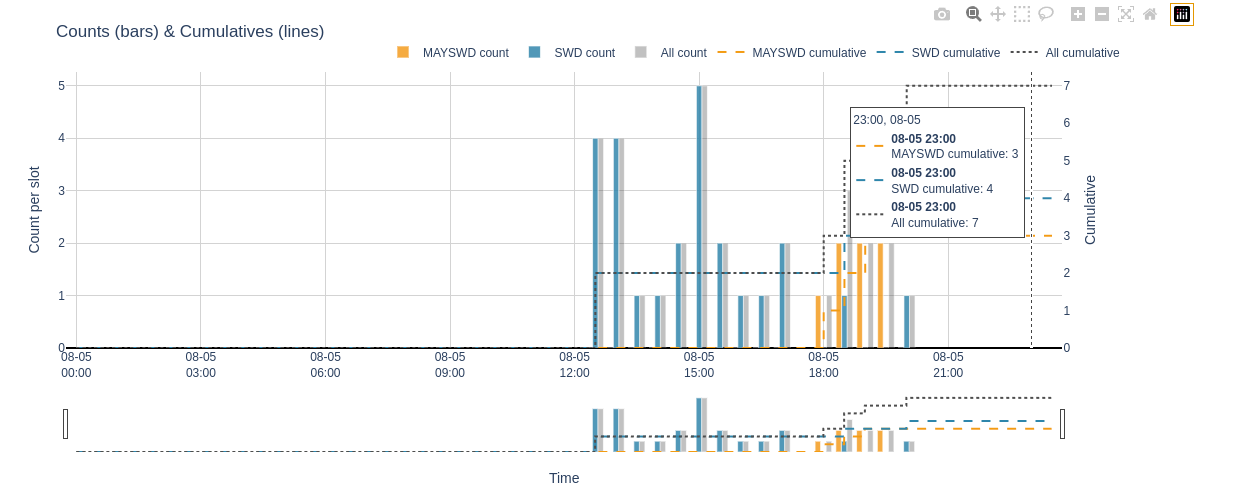

In [16]:
for d in chosen_dirs:
    print(f"\n=========绘图目录：{d} =========")
    chart_path = Path("/workspace/models/SAHI/charts")
    CSV = d.parent / "raw_data_sliced_merge" / f"cls_{version}" / "11_time_series.csv"
    HTML = chart_path / f"time_series_chart_{version}" / f"{d.parent.name}.html"
    HTML.parent.mkdir(parents=True, exist_ok=True)

    if not CSV.exists():
        print(f"跳过（CSV 不存在）：{CSV}")
        continue    
    plot_trap_timeseries(
        CSV,
        barmode="group",
        save_html=HTML,
        title=f"Counts (bars) & Cumulatives (lines) - {d.parent.name}"
    )
    print(f"已保存到 {HTML}")



=========绘图目录：/workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v1/ms1_0726-0809_11.html


# 持久 ID 赋值 + 可视化工具

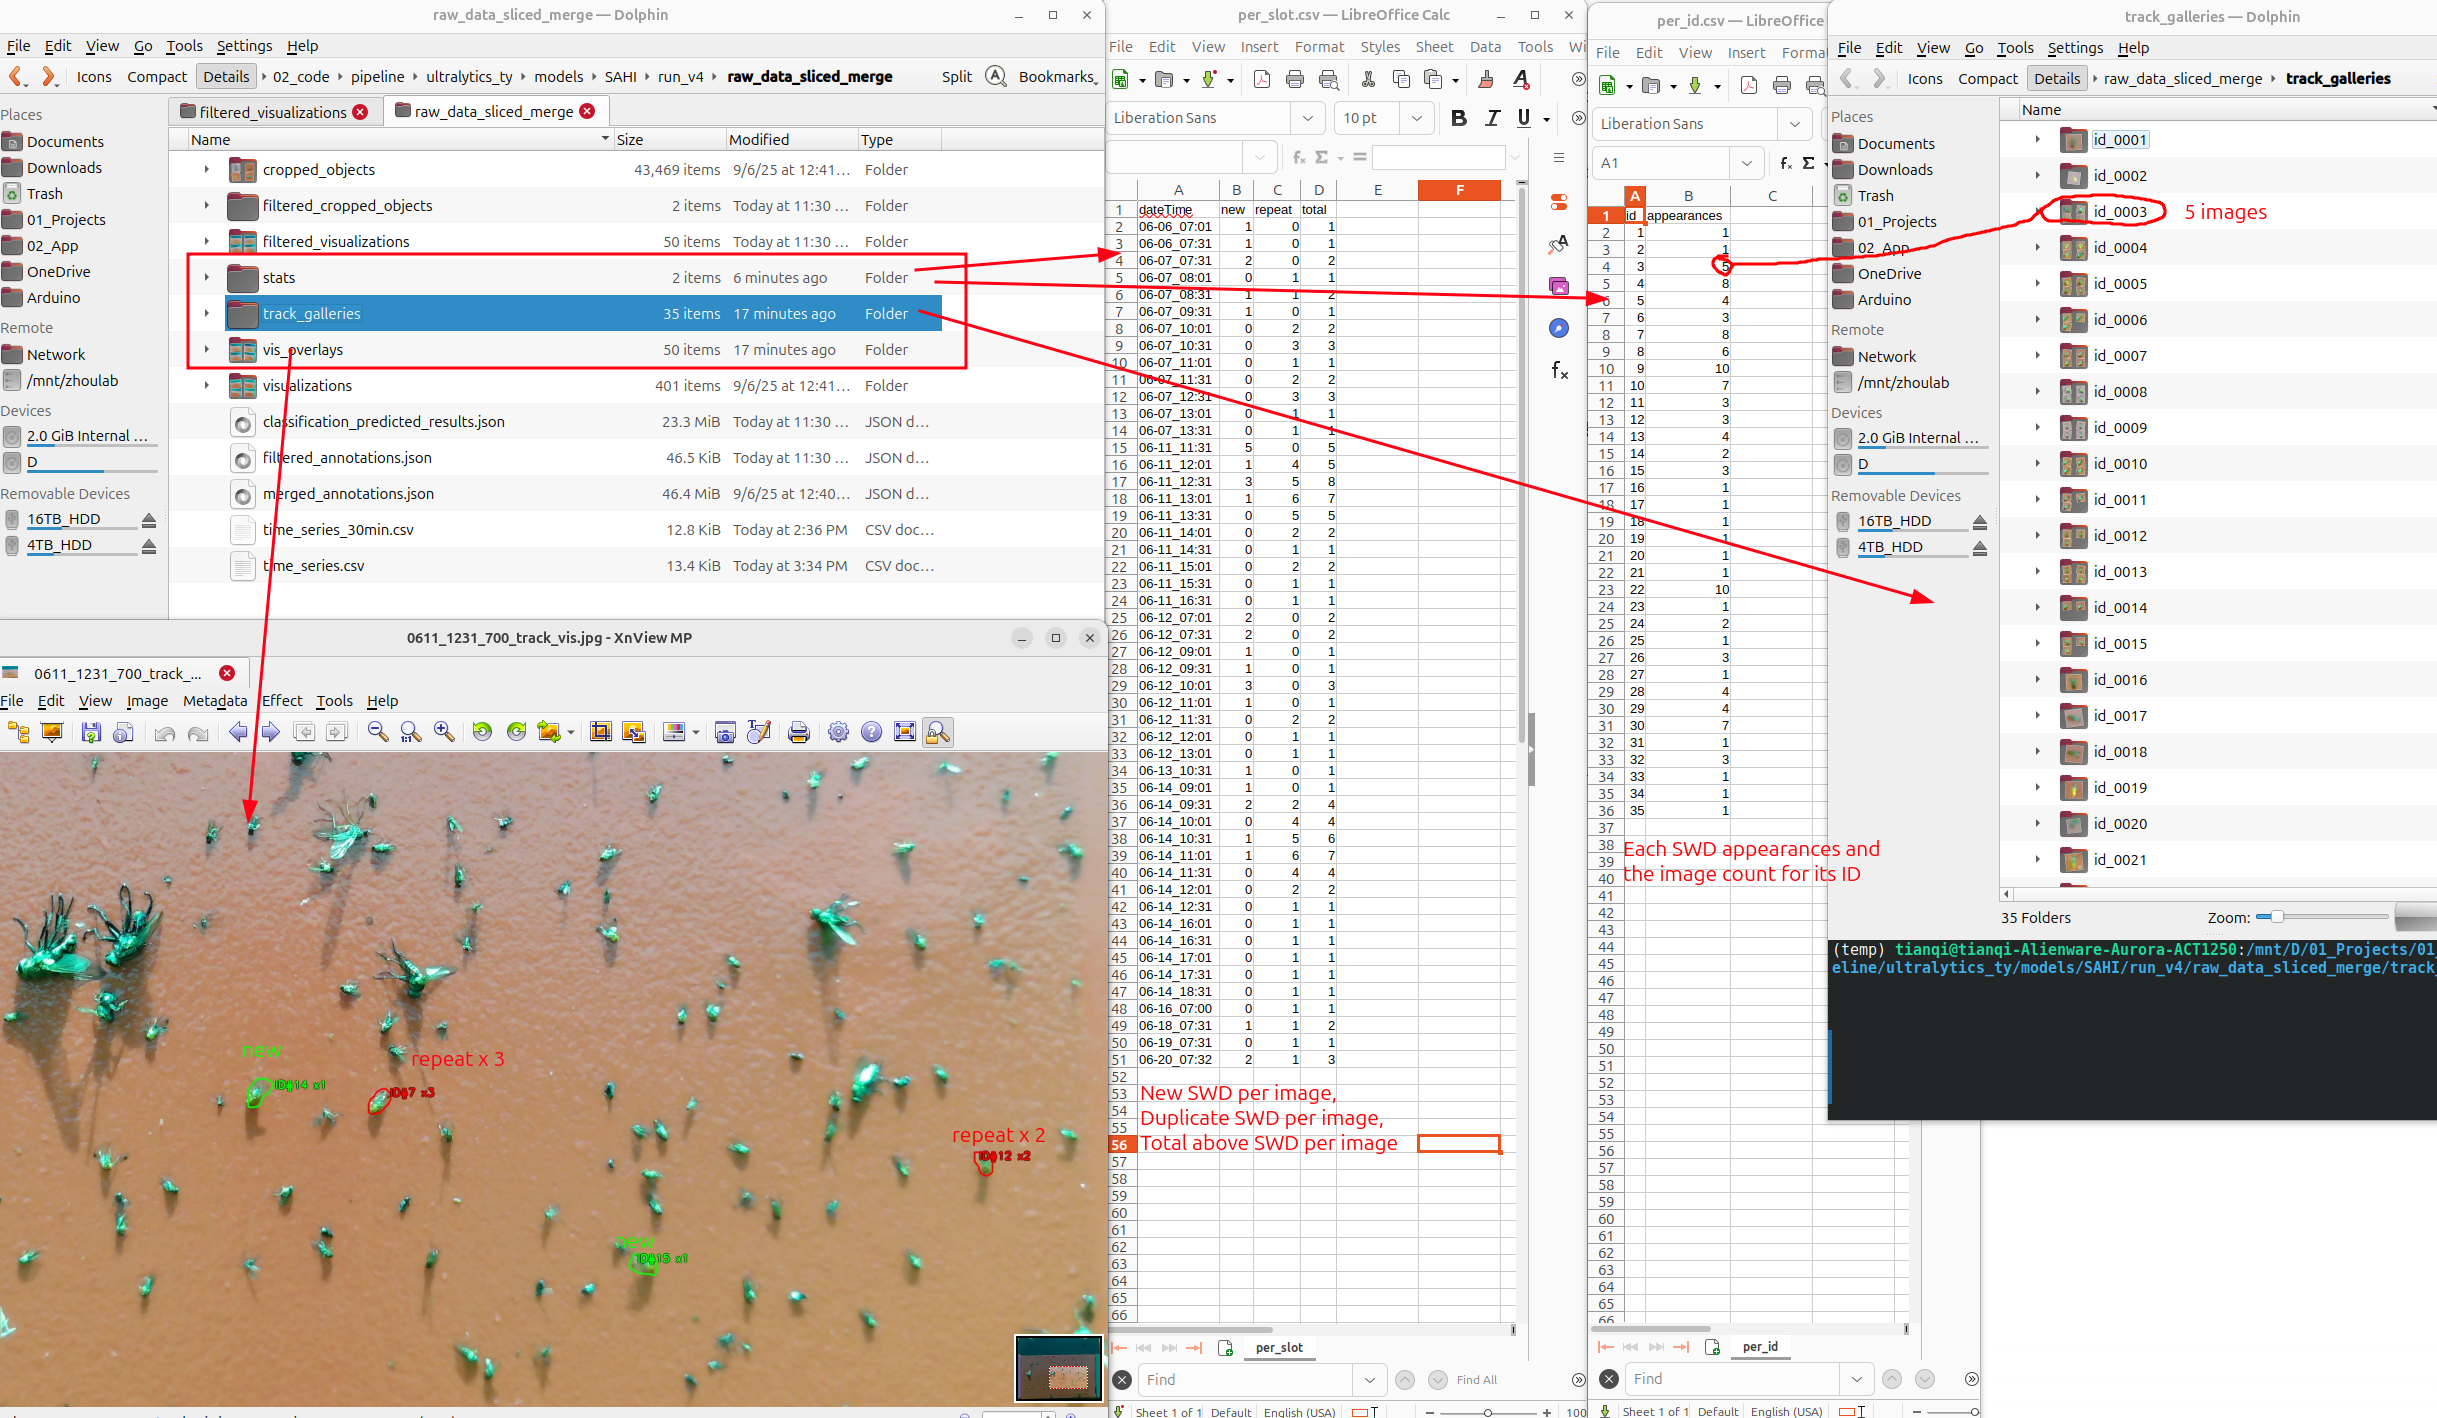

In [23]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os, math, csv, re
from pathlib import Path
from collections import defaultdict, Counter
from typing import Any, Dict, List, Optional, Tuple, Iterable

import orjson
import numpy as np
import cv2

# ============== 可选 shapely（用于多边形 IOS/IOU），无则自动退回 bbox ==============
try:
    from shapely.geometry import Polygon
    _HAVE_SHAPELY = True
except Exception:
    _HAVE_SHAPELY = False

# ============== 时间解析（与你现有命名一致：MMDD_HHMM） ==============
_FN_RE = re.compile(r"(?P<mm>\d{2})(?P<dd>\d{2})_(?P<hh>\d{2})(?P<mi>\d{2})")

def _parse_mmdd_hhmm(img_name: str):
    m = _FN_RE.search(img_name)
    if not m: return None
    mm, dd, hh, mi = m.group("mm", "dd", "hh", "mi")
    return f"{mm}-{dd}", f"{hh}:{mi}"

def _time_sort_key(t: str):
    return (int(t[:2]), int(t[3:]))

# ============== IO ==============
def json_load(path: str):
    with open(path, "rb") as f:
        return orjson.loads(f.read())

def json_dump(obj, path: str):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, "wb") as f:
        f.write(orjson.dumps(obj, option=orjson.OPT_INDENT_2))

# ============== 读取 time_series_v9.csv，仅使用其中的 last_selected_image ==============
def load_selected_from_timeseries(csv_path: Path) -> Tuple[set, Dict[str, Tuple[str,str]], Dict[Tuple[str,str], Tuple[int,int]]]:
    """
    返回：
      selected_images: {img_stem, ...}
      image_to_slot: {img_stem: (date, time)}
      slot_counts: {(date, time): (total, cumulative_total)}
    备注：忽略 last_selected_image 为空的行；重复出现时后者覆盖前者（通常不会重复）。
    """
    selected_images = set()
    image_to_slot: Dict[str, Tuple[str,str]] = {}
    slot_counts: Dict[Tuple[str,str], Tuple[int,int]] = {}
    if not csv_path.exists():
        raise FileNotFoundError(f"time_series csv not found: {csv_path}")

    with open(csv_path, "r", encoding="utf-8") as f:
        r = csv.DictReader(f)
        req = {"date","time","last_selected_image","total","cumulative_total"}
        missing = req - set([h.strip() for h in r.fieldnames or []])
        if missing:
            raise ValueError(f"{csv_path.name} 缺少列: {missing}")

        for row in r:
            img = (row.get("last_selected_image") or "").strip()
            if not img:
                continue
            date = (row.get("date") or "").strip()
            time = (row.get("time") or "").strip()
            try:
                total = int(float(row.get("total", "0")))  # 兼容"1.0"
            except Exception:
                total = 0
            try:
                cum = int(float(row.get("cumulative_total", "0")))
            except Exception:
                cum = 0

            selected_images.add(img)
            image_to_slot[img] = (date, time)
            slot_counts[(date, time)] = (total, cum)

    return selected_images, image_to_slot, slot_counts

# ============== 原图索引 ==============
def _build_image_index(original_image_dir: str) -> Dict[str, str]:
    idx: Dict[str, str] = {}
    for p in Path(original_image_dir).glob("*.jpg"):
        idx[p.stem] = str(p)
    return idx

# ============== 几何工具 ==============
def _poly_from_segments(segments: Dict[str, List[float]]) -> Optional[List[List[float]]]:
    xs = segments.get("x") or segments.get("xs") or []
    ys = segments.get("y") or segments.get("ys") or []
    if not xs or not ys or len(xs) != len(ys): return None
    return [[float(x), float(y)] for x, y in zip(xs, ys)]

def _poly_from_bbox(b) -> Optional[List[List[float]]]:
    if b is None: return None
    try:
        if isinstance(b, (list, tuple)) and len(b) >= 4:
            x, y, w, h = map(float, b[:4])
            if w > 0 and h > 0:
                x1, y1, x2, y2 = x, y, x + w, y + h
            else:
                x1, y1, x2, y2 = map(float, b[:4])
        elif isinstance(b, dict):
            if all(k in b for k in ("x1","y1","x2","y2")):
                x1, y1, x2, y2 = float(b["x1"]), float(b["y1"]), float(b["x2"]), float(b["y2"])
            else:
                x = float(b.get("x")); y = float(b.get("y"))
                w = float(b.get("w") or b.get("width")); h = float(b.get("h") or b.get("height"))
                x1, y1, x2, y2 = x, y, x + w, y + h
        else:
            return None
        if x2 <= x1 or y2 <= y1: return None
        return [[x1,y1],[x2,y1],[x2,y2],[x1,y2]]
    except Exception:
        return None

def _poly_to_bbox(poly: List[List[float]]) -> Tuple[float,float,float,float]:
    xs = [p[0] for p in poly]; ys = [p[1] for p in poly]
    return min(xs), min(ys), max(xs), max(ys)

def _area_bbox(b):
    return max(0.0, b[2]-b[0]) * max(0.0, b[3]-b[1])

def _bbox_center(b: Tuple[float,float,float,float]) -> Tuple[float,float]:
    return (b[0]+b[2]) * 0.5, (b[1]+b[3]) * 0.5

def _center_distance(b1, b2) -> float:
    c1 = _bbox_center(b1); c2 = _bbox_center(b2)
    return math.hypot(c1[0]-c2[0], c1[1]-c2[1])

def _iou_bbox(a, b) -> float:
    xA = max(a[0], b[0]); yA = max(a[1], b[1])
    xB = min(a[2], b[2]); yB = min(a[3], b[3])
    inter = max(0.0, xB-xA) * max(0.0, yB-yA)
    if inter <= 0: return 0.0
    u = _area_bbox(a) + _area_bbox(b) - inter
    return inter / u if u > 0 else 0.0

def _ios_bbox(a, b) -> float:
    xA = max(a[0], b[0]); yA = max(a[1], b[1])
    xB = min(a[2], b[2]); yB = min(a[3], b[3])
    inter = max(0.0, xB-xA) * max(0.0, yB-yA)
    if inter <= 0: return 0.0
    smaller = min(_area_bbox(a), _area_bbox(b))
    return inter / smaller if smaller > 0 else 0.0

def _iou_poly(pa, pb) -> float:
    if not _HAVE_SHAPELY:
        return _iou_bbox(_poly_to_bbox(pa), _poly_to_bbox(pb))
    try:
        A = Polygon(pa); B = Polygon(pb)
        inter = A.intersection(B).area
        if inter <= 0: return 0.0
        u = A.area + B.area - inter
        return inter / u if u > 0 else 0.0
    except Exception:
        return _iou_bbox(_poly_to_bbox(pa), _poly_to_bbox(pb))

def _ios_poly(pa, pb) -> float:
    if not _HAVE_SHAPELY:
        return _ios_bbox(_poly_to_bbox(pa), _poly_to_bbox(pb))
    try:
        A = Polygon(pa); B = Polygon(pb)
        inter = A.intersection(B).area
        if inter <= 0: return 0.0
        smaller = min(A.area, B.area)
        return inter / smaller if smaller > 0 else 0.0
    except Exception:
        return _ios_bbox(_poly_to_bbox(pa), _poly_to_bbox(pb))

def _extract_poly(obj: Dict[str,Any]) -> Optional[List[List[float]]]:
    pts = obj.get("points") or obj.get("polygon")
    if isinstance(pts, list) and len(pts) >= 3:
        return [[float(x), float(y)] for x, y in pts]
    seg = obj.get("segments") or obj.get("segment")
    if isinstance(seg, dict):
        p = _poly_from_segments(seg)
        if p: return p
    box = obj.get("box") or obj.get("Box")
    if box is not None:
        p = _poly_from_bbox(box)
        if p: return p
    bb = obj.get("bbox") or obj.get("BBox")
    if bb is not None:
        p = _poly_from_bbox(bb)
        if p: return p
    return None

# ============== 赋持久 ID（跨时刻去重，与累计逻辑一致） ==============
def assign_persistent_ids(
    cleaned_annotations: Dict[str, List[Dict[str,Any]]],
    match_metric: str = "poly_ios",     # 'poly_ios' | 'poly_iou' | 'bbox_ios' | 'bbox_iou'
    match_threshold: float = 0.5,
    center_thresh: Optional[float] = 20.0,
    class_agnostic: bool = False
):
    # —— 组织按时间顺序 —— 
    by_date_time: Dict[Tuple[str,str], List[Tuple[str,Dict]]] = defaultdict(list)
    for img, anns in cleaned_annotations.items():
        parsed = _parse_mmdd_hhmm(img)
        if not parsed: 
            continue
        d, t = parsed
        for a in anns:
            poly = _extract_poly(a)
            by_date_time[(d,t)].append((img, {"label": str(a.get("label","")), "poly": poly}))

    slots = sorted(by_date_time.keys(), key=lambda k: (int(k[0][:2]), int(k[0][3:]), *_time_sort_key(k[1])))

    # —— 度量函数 —— 
    mm = match_metric.lower()
    def score(pa, pb):
        if "poly" in mm and (pa is not None) and (pb is not None):
            return _ios_poly(pa, pb) if "ios" in mm else _iou_poly(pa, pb)
        # fallback bbox
        if pa is None or pb is None: return 0.0
        ba, bb = _poly_to_bbox(pa), _poly_to_bbox(pb)
        if center_thresh is not None and _center_distance(ba, bb) > center_thresh:
            return 0.0
        return _ios_bbox(ba, bb) if "ios" in mm else _iou_bbox(ba, bb)

    # —— 已见库 & 输出结构 —— 
    next_id = 1
    pool_by_label = defaultdict(list)   # label -> List[{'id','poly','last_dt'}]
    pool_all: List[Dict[str,Any]] = []  # class_agnostic 时使用
    id_tracks = defaultdict(list)       # id -> List[{'date','time','img','poly','label','repeat_idx'}]
    timeline = []                       # 每条观测（时序展开）

    for (d,t) in slots:
        obs = by_date_time[(d,t)]  # List[(img, det)]
        # 先做“本时刻内部去重”
        unique_obs: List[Tuple[str,Dict]] = []
        for img, det in obs:
            dup_in_row = False
            for _, u in unique_obs:
                if (not class_agnostic) and (u["label"] != det["label"]):
                    continue
                if score(det["poly"], u["poly"]) >= match_threshold:
                    dup_in_row = True
                    break
            if not dup_in_row:
                unique_obs.append((img, det))

        # 与历史库匹配 → 赋 ID
        for img, det in unique_obs:
            label, poly = det["label"], det["poly"]
            candidates = pool_all if class_agnostic else pool_by_label[label]
            best = None; best_s = -1.0
            if poly is not None:
                for c in candidates:
                    s = score(poly, c["poly"])
                    if s >= match_threshold and s > best_s:
                        best = c; best_s = s

            if best is None:
                cur_id = next_id; next_id += 1
                entry = {"id": cur_id, "poly": poly, "last_dt": (d,t)}
                if class_agnostic: pool_all.append(entry)
                else: pool_by_label[label].append(entry)
                repeat_idx = 1
            else:
                cur_id = best["id"]
                best["poly"] = poly if poly is not None else best["poly"]
                best["last_dt"] = (d,t)
                repeat_idx = len(id_tracks[cur_id]) + 1

            id_tracks[cur_id].append({
                "date": d, "time": t, "img": img, "poly": poly, "label": label, "repeat_idx": repeat_idx
            })
            timeline.append({
                "date": d, "time": t, "img": img, "label": label,
                "id": cur_id, "is_new": repeat_idx == 1, "repeat_idx": repeat_idx, "poly": poly
            })

    return timeline, id_tracks

# ============== 右上角计数徽标（醒目显示 now/cum） ==============
def _draw_top_right_counter(canvas: np.ndarray, now: int, cum: int):
    """
    在右上角绘制大号计数徽标：
      第1行：NOW: <now>
      第2行：Σ: <cum>
    半透明黑底、白字、粗体。自动随图宽度调整字号。
    """
    H, W = canvas.shape[:2]
    margin = max(8, W // 200)         # 外边距
    pad = max(8, W // 300)            # 内边距
    font = cv2.FONT_HERSHEY_SIMPLEX
    # 字号随宽度而变（在 0.8 ~ 2.2 之间）
    font_scale = max(0.8, min(2.2, W / 800.0))
    thickness = max(2, int(round(font_scale + 1)))

    line1 = f"NOW: {now}"
    line2 = f"SUM: {cum}"  # 用 SUM/Σ 避免中文乱码

    (w1, h1), _ = cv2.getTextSize(line1, font, font_scale, thickness)
    (w2, h2), _ = cv2.getTextSize(line2, font, font_scale, thickness)
    box_w = max(w1, w2) + 2 * pad
    line_gap = max(6, int(0.25 * h1))
    box_h = h1 + h2 + line_gap + 2 * pad

    x2 = W - margin
    y1 = margin
    x1 = x2 - box_w
    y2 = y1 + box_h

    # 半透明黑底
    overlay = canvas.copy()
    cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 0, 0), thickness=-1)
    alpha = 0.55
    cv2.addWeighted(overlay, alpha, canvas, 1 - alpha, 0, dst=canvas)

    # 白字
    tx = x1 + pad
    ty1 = y1 + pad + h1
    ty2 = ty1 + line_gap + h2
    cv2.putText(canvas, line1, (tx, ty1), font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)
    cv2.putText(canvas, line2, (tx, ty2), font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

# ============== 可视化：叠加绘制（新=绿，重复=红，右上角大号计数徽标） ==============
def draw_overlays(
    timeline: List[Dict[str,Any]],
    original_image_dir: str,
    out_dir: str,
    draw_text: bool = True,
    ghost_trail_steps: int = 0,          # >0 开启“幽灵轨迹”
    ghost_alpha: float = 0.25,           # 幽灵透明度
    slot_counts_for_image: Optional[Dict[str, Tuple[int,int]]] = None  # img -> (now, cum)
):
    os.makedirs(out_dir, exist_ok=True)
    image_index = _build_image_index(original_image_dir)

    # 分图聚合
    by_img = defaultdict(list)
    for r in timeline:
        by_img[r["img"]].append(r)

    # 为“幽灵轨迹”建立 id -> 历史 occurrences
    hist_by_id = defaultdict(list)
    def dt_key(r): return (int(r["date"][:2]), int(r["date"][3:]), int(r["time"][:2]), int(r["time"][3:]))
    timeline_sorted = sorted(timeline, key=dt_key)
    for r in timeline_sorted:
        hist_by_id[r["id"]].append(r)

    for img, rows in by_img.items():
        path = image_index.get(img)
        if path is None or not os.path.exists(path):
            # 兜底：前缀匹配
            for p in Path(original_image_dir).glob(f"{img}*.jpg"):
                path = str(p); break
        if path is None or not os.path.exists(path):
            continue

        canvas = cv2.imread(path)
        if canvas is None: 
            continue

        # 先画幽灵轨迹（淡色）
        if ghost_trail_steps > 0:
            ghost = canvas.copy()
            for r in rows:
                tr = hist_by_id[r["id"]]
                idx = None
                for i, k in enumerate(tr):
                    if k["img"] == img: idx = i; break
                if idx is None: continue
                start = max(0, idx - ghost_trail_steps)
                for j in range(start, idx):
                    pj = tr[j]
                    if pj["poly"] is None: continue
                    pts = np.asarray(pj["poly"], dtype=np.int32).reshape(-1,1,2)
                    cv2.polylines(ghost, [pts], True, (200,200,200), 1, cv2.LINE_AA)
            canvas = cv2.addWeighted(ghost, ghost_alpha, canvas, 1-ghost_alpha, 0)

        # 再画当前 detections（新=绿，重复=红）
        for r in rows:
            poly = r["poly"]
            if poly is None: 
                continue
            pts = np.asarray(poly, dtype=np.int32).reshape(-1,1,2)
            color = (0,255,0) if r["is_new"] else (0,0,255)
            cv2.polylines(canvas, [pts], True, color, 2, cv2.LINE_AA)

            if draw_text:
                x1, y1, x2, y2 = _poly_to_bbox(poly)
                x0, y0 = int(x1) + 8, int(y1) + 18
                label = str(r.get("label", ""))  # e.g. "swd" / "mayswd"
                txt = f"ID#{r['id']} {label} x{r['repeat_idx']}"
                SHIFT_X = 64
                cv2.putText(canvas, txt, (x0 + SHIFT_X, y0), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, cv2.LINE_AA)

        # 右上角计数徽标（来自 CSV 的 total / cumulative_total）
        if slot_counts_for_image is not None and img in slot_counts_for_image:
            now, cum = slot_counts_for_image[img]
            _draw_top_right_counter(canvas, now=now, cum=cum)

        out_path = os.path.join(out_dir, f"{img}_track_vis.jpg")
        cv2.imwrite(out_path, canvas, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

# ============== 轨迹相册：按 ID 导出裁剪序列（时间排序） ==============
def _crop_square(img, poly, margin: int = 8):
    H, W = img.shape[:2]
    xs = [p[0] for p in poly]; ys = [p[1] for p in poly]
    x1, y1, x2, y2 = int(min(xs)), int(min(ys)), int(max(xs)), int(max(ys))
    side = max(x2 - x1, y2 - y1)
    cx = (x1 + x2) // 2; cy = (y1 + y2) // 2
    l = max(0, cx - side//2 - margin)
    t = max(0, cy - side//2 - margin)
    r = min(W, cx + side//2 + margin)
    b = min(H, cy + side//2 + margin)
    if r - l <= 1 or b - t <= 1: return None
    return img[t:b, l:r].copy()

def build_track_galleries(
    id_tracks: Dict[int, List[Dict[str,Any]]],
    original_image_dir: str,
    out_dir: str,
    margin: int = 8,
    workers: Optional[int] = None,
    jpeg_quality: int = 90
):
    import concurrent.futures

    os.makedirs(out_dir, exist_ok=True)
    image_index = _build_image_index(original_image_dir)

    save_dirs = {}
    for tid in id_tracks.keys():
        d = os.path.join(out_dir, f"id_{tid:04d}")
        os.makedirs(d, exist_ok=True)
        save_dirs[tid] = d

    tasks_by_img: Dict[str, List[Tuple[List[List[float]], str]]] = defaultdict(list)
    _fallback_cache: Dict[str, Optional[str]] = {}

    for tid, occs in id_tracks.items():
        occs_sorted = sorted(
            occs, key=lambda r: (int(r["date"][:2]), int(r["date"][3:]), int(r["time"][:2]), int(r["time"][3:]))
        )
        for k, r in enumerate(occs_sorted, start=1):
            if r.get("poly") is None:
                continue

            img_key = r["img"]
            img_path = image_index.get(img_key)
            if img_path is None:
                if img_key not in _fallback_cache:
                    hit = None
                    for p in Path(original_image_dir).glob(f"{img_key}*.jpg"):
                        hit = str(p); break
                    _fallback_cache[img_key] = hit
                img_path = _fallback_cache[img_key]

            if not img_path or not os.path.exists(img_path):
                continue

            fn = f"{k:02d}_{r['date']}_{r['time']}_{r['img']}.jpg"
            save_path = os.path.join(save_dirs[tid], fn)
            tasks_by_img[img_path].append((r["poly"], save_path))

    if not tasks_by_img:
        return

    encode_params = [int(cv2.IMWRITE_JPEG_QUALITY), int(jpeg_quality)]

    def _process_one_image(img_path: str, todo: List[Tuple[List[List[float]], str]]):
        img = cv2.imread(img_path)
        if img is None:
            return 0
        ok = 0
        for poly, save_path in todo:
            crop = _crop_square(img, poly, margin=margin)
            if crop is None:
                continue
            cv2.imwrite(save_path, crop, encode_params)
            ok += 1
        return ok

    if workers is None:
        workers = min(32, (os.cpu_count() or 4) + 4)

    import concurrent.futures
    with concurrent.futures.ThreadPoolExecutor(max_workers=workers) as ex:
        futs = [ex.submit(_process_one_image, path, todo) for path, todo in tasks_by_img.items()]
        for _ in concurrent.futures.as_completed(futs):
            pass

# ============== 统计导出：每时刻新增/重复 & 每 ID 出现次数 ==============
def export_stats_csv(
    timeline: List[Dict[str,Any]],
    csv_per_slot: str,
    csv_per_id: str
):
    from collections import defaultdict, Counter

    labels = sorted({str(r.get("label","")) for r in timeline})

    def slot_key(r):
        return (int(r["date"][:2]), int(r["date"][3:]), int(r["time"][:2]), int(r["time"][3:]))

    per_slot_totals = defaultdict(lambda: {"new":0, "repeat":0, "total":0})
    per_slot_new_by_lbl = defaultdict(Counter)
    per_slot_rep_by_lbl = defaultdict(Counter)

    for r in timeline:
        dt_key = f"{r['date']}_{r['time']}"
        per_slot_totals[dt_key]["total"] += 1
        if r.get("is_new", False):
            per_slot_totals[dt_key]["new"] += 1
            per_slot_new_by_lbl[dt_key][str(r.get("label",""))] += 1
        else:
            per_slot_totals[dt_key]["repeat"] += 1
            per_slot_rep_by_lbl[dt_key][str(r.get("label",""))] += 1

    all_slots = sorted(
        { (r["date"], r["time"]) for r in timeline },
        key=lambda dt: (int(dt[0][:2]), int(dt[0][3:]), int(dt[1][:2]), int(dt[1][3:]))
    )
    sorted_keys = [f"{d}_{t}" for d, t in all_slots]

    Path(csv_per_slot).parent.mkdir(parents=True, exist_ok=True)

    header = ["dateTime", "new", "repeat", "total", "cumulative_total"]
    for lbl in labels:
        header += [f"{lbl}_new", f"{lbl}_repeat", f"{lbl}", f"{lbl}_cumulative"]

    running_cum_total = 0
    running_cum_by_lbl = {lbl: 0 for lbl in labels}

    with open(csv_per_slot, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(header)

        for k in sorted_keys:
            base = per_slot_totals[k]
            new_by_lbl = per_slot_new_by_lbl[k]
            rep_by_lbl = per_slot_rep_by_lbl[k]

            running_cum_total += base["new"]
            for lbl in labels:
                running_cum_by_lbl[lbl] += new_by_lbl.get(lbl, 0)

            row = [k, base["new"], base["repeat"], base["total"], running_cum_total]
            for lbl in labels:
                n = new_by_lbl.get(lbl, 0)
                r_ = rep_by_lbl.get(lbl, 0)
                row += [n, r_, n + r_, running_cum_by_lbl[lbl]]

            w.writerow(row)

    count_by_id = Counter([r["id"] for r in timeline])
    label_by_id = {}
    for r in timeline:
        if r["id"] not in label_by_id:
            label_by_id[r["id"]] = r.get("label","")
    with open(csv_per_id, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["id","appearances", "label"])
        for tid in sorted(count_by_id.keys()):
            w.writerow([tid, count_by_id[tid], label_by_id.get(tid,"")])

In [24]:
# ============== 主流程（示例：遍历 chosen_dirs） ==============
# 假设 chosen_dirs 与 version 定义于你外层脚本
for d in chosen_dirs:
    print(f"\n========= 轨迹分析目录：{d} =========")
    filtered_annotations_json_path = d.parent / "raw_data_sliced_merge" / f"cls_{version}" / "03_filtered_annotations.json"
    original_image_dir = d.parent / "raw_data"
    out_vis_overlays_dir = d.parent / "raw_data_sliced_merge" / f"cls_{version}" / "12_vis_overlays"
    out_track_galleries_dir = d.parent / "raw_data_sliced_merge" / f"cls_{version}" / "12_track_galleries"
    out_stats_per_slot_csv = d.parent / "raw_data_sliced_merge" / f"cls_{version}" / "12_stats" / "per_slot.csv"
    out_stats_per_id_csv = d.parent / "raw_data_sliced_merge" / f"cls_{version}" / "12_stats" / "per_id.csv"

    # -1） 清理输出目录
    for p in [out_vis_overlays_dir, out_track_galleries_dir, out_stats_per_slot_csv, out_stats_per_id_csv]:
        if os.path.exists(p):
            if os.path.isfile(p):
                os.remove(p)
            else:
                import shutil
                shutil.rmtree(p)

    # 0) 读取 time_series.csv（白名单 + 计数）
    time_series_csv = d.parent / "raw_data_sliced_merge" / f"cls_{version}" / "11_time_series.csv"
    if not time_series_csv.exists():
        print(f"[warn] {time_series_csv} 不存在，跳过该目录。")
        continue
    selected_images, image_to_slot, slot_counts = load_selected_from_timeseries(time_series_csv)
    print(f"[time_series] 入选图片数: {len(selected_images)}")

    # 1) 读入“清洗后的”标注，并按 CSV 白名单过滤
    cleaned_all = json_load(filtered_annotations_json_path)
    cleaned = {img: anns for img, anns in cleaned_all.items() if img in selected_images}
    missing = len(selected_images - set(cleaned.keys()))
    if missing:
        print(f"[filter] CSV中有 {missing} 张在清洗标注里未找到（将被跳过）")

    if not cleaned:
        print("[warn] 无可用数据（过滤后为空），跳过该目录。")
        continue

    # 1.5) 构造 img -> (now, cum) 的映射（用于右上角徽标）
    slot_counts_for_image: Dict[str, Tuple[int,int]] = {}
    for img in cleaned.keys():
        dt = image_to_slot.get(img)
        if dt is None: 
            continue
        counts = slot_counts.get(dt)
        if counts is not None:
            slot_counts_for_image[img] = counts

    # 2) 先赋持久 ID（参数与累计一致）—— 仅在白名单图片上进行
    timeline, id_tracks = assign_persistent_ids(
        cleaned_annotations=cleaned,
        match_metric="poly_ios",       # 'poly_ios' | 'poly_iou' | 'bbox_ios' | 'bbox_iou'
        match_threshold=0.5,
        center_thresh=20.0,
        class_agnostic=False
    )

    # 3) 叠加可视化（新=绿，重复=红）+ 右上角计数徽标（now/cum）
    draw_overlays(
        timeline,
        original_image_dir=str(original_image_dir),
        out_dir=str(out_vis_overlays_dir),
        draw_text=True,
        ghost_trail_steps=2,    # 0 关闭；2 表示叠加过去2次的位置（淡灰）
        ghost_alpha=0.25,
        slot_counts_for_image=slot_counts_for_image
    )

    # 4) 为每个 ID 导出“轨迹相册”（按时间排序的一组裁剪小图）
    build_track_galleries(
        id_tracks,
        original_image_dir=str(original_image_dir),
        out_dir=str(out_track_galleries_dir),
        margin=8
    )

    # 5) 导出统计表（基于白名单后的 timeline）
    export_stats_csv(
        timeline,
        csv_per_slot=str(out_stats_per_slot_csv),   # 每个时刻：new / repeat / total
        csv_per_id=str(out_stats_per_id_csv)        # 每个ID出现次数
    )

    # 6) 根据 per_id.csv 重命名轨迹相册目录
    id_rename_map = {}
    with open(out_stats_per_id_csv, "r", encoding="utf-8") as f:
        r = csv.reader(f)
        next(r, None)
        for row in r:
            if len(row) >= 3:
                tid = int(row[0]); appearances = int(row[1]); label = row[2] or "unknown"
                id_rename_map[tid] = (appearances, label)
    for tid, (appearances, label) in id_rename_map.items():
        src_dir = out_track_galleries_dir / f"id_{tid:04d}"
        if not src_dir.exists():
            continue
        dst_dir = out_track_galleries_dir / f"id_{tid:04d}_x{appearances}_{label}"
        if dst_dir.exists():
            continue
        src_dir.rename(dst_dir)



========= 轨迹分析目录：/workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge =========
[time_series] 入选图片数: 0
[warn] 无可用数据（过滤后为空），跳过该目录。
